## Utils

In [1]:
from math import sqrt, log

import scipy
from scipy.stats import multivariate_normal, norm as normal
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

In [2]:
params = { 'figure.figsize': (20, 10),
           'axes.grid': True,
          
#            'font.size': 15,
           'axes.titlesize': 25,
           'axes.labelsize': 20,
          
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
          
           'legend.fontsize': 20,
         }
matplotlib.rcParams.update(params)

In [3]:
# matplotlib.rcParams.keys()

In [4]:
def show_plot(title='<title>', x_label='<x_label>', y_label='<y_label>', axis_mode='equal'):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=0)
    plt.axis(axis_mode)
    plt.show()

## Point set generation

In [5]:
# for result reproduction
np.random.seed(23)


# first class
y1_mean = [0, 0]
y1_cov = [[70, 0], [0, 5]]
y1 = multivariate_normal(y1_mean, y1_cov)
y1_prob = 0.75


# second class
y2_mean = [16, 4]
y2_cov = [[40, 0], [0, 60]]
y2 = multivariate_normal(y2_mean, y2_cov)


# TODO: try to generate more data
# - how it affects on NB precision?
# point generation
full_point_count = 300
y1_points, y2_points = [], []
for _ in range(full_point_count):
    if np.random.uniform() > y1_prob:
        y2_points.append(y2.rvs())
    else:
        y1_points.append(y1.rvs())


# converting to np arrays
y1_points = np.array(y1_points)
y2_points = np.array(y2_points)


# showing shape
# print('y1_points (head):\n%s' % y1_points[:10])
# print('y2_points (head):\n%s' % y2_points[:10])

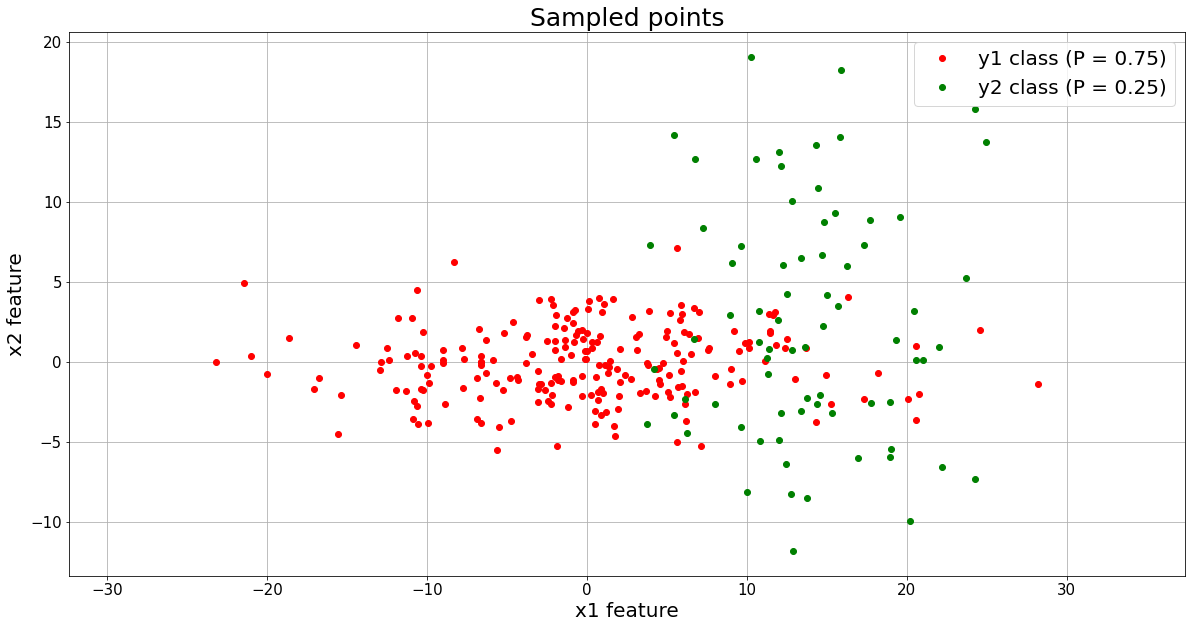

In [6]:
# plotting sampled points
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
show_plot('Sampled points', 'x1 feature', 'x2 feature')

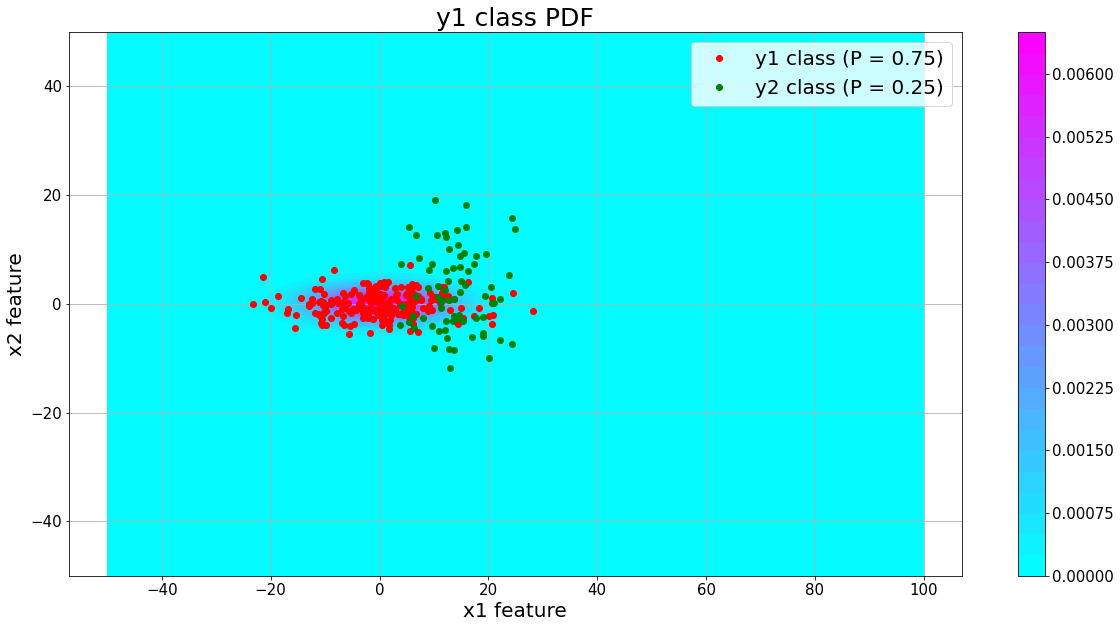

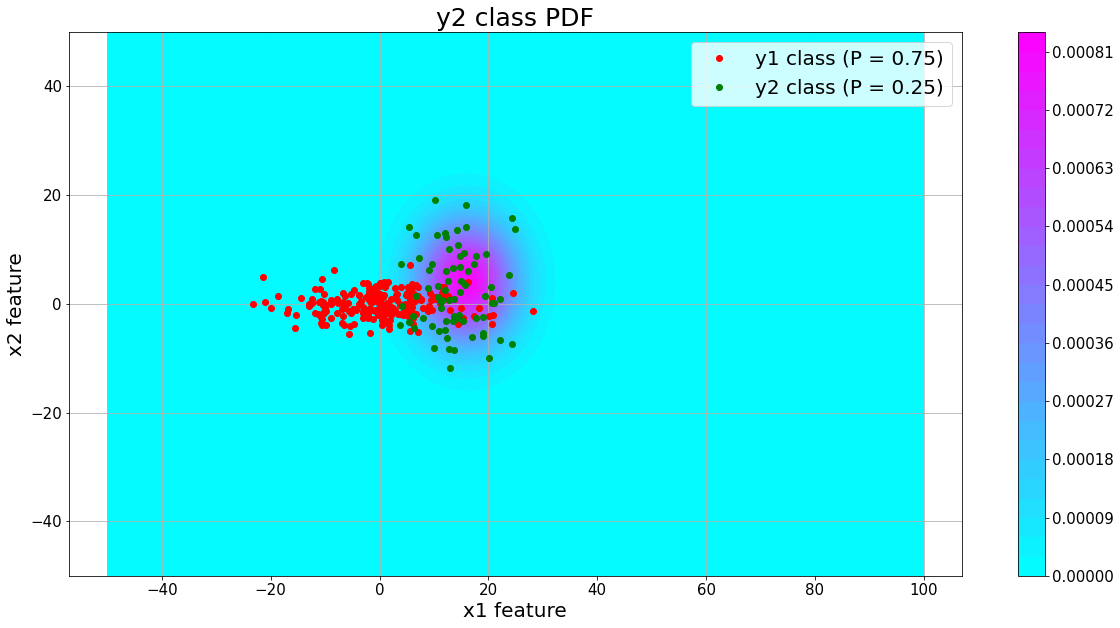

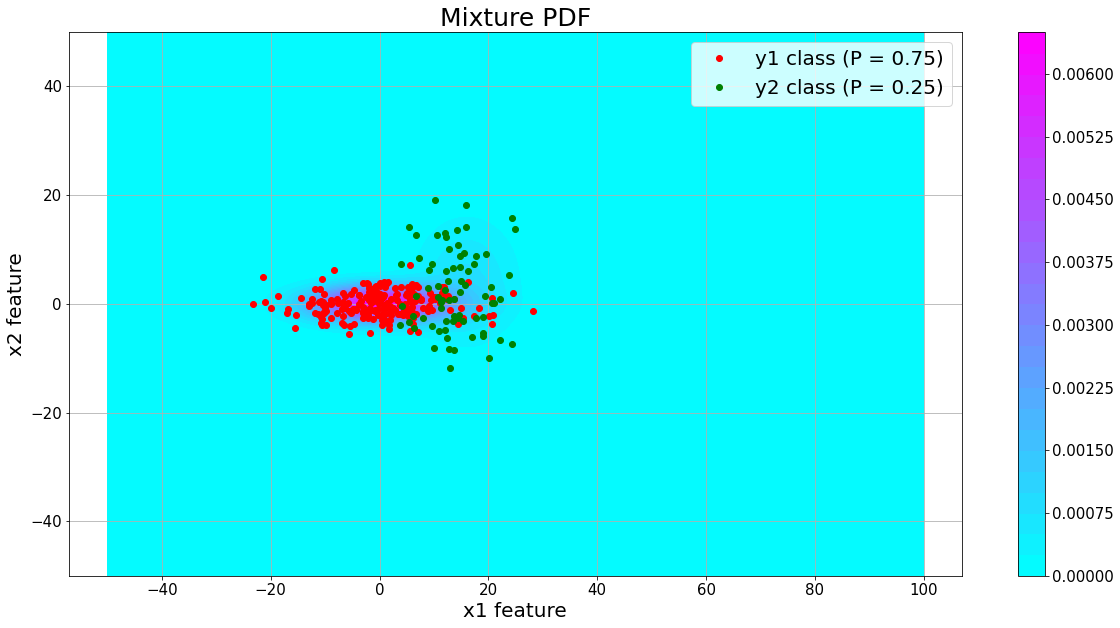

In [7]:
# PDFs
# grid
x1_grid, x2_grid = np.mgrid[-50:100:0.1, -50:50:0.1]
coords = np.empty(x1_grid.shape + (2,))
coords[:, :, 0] = x1_grid
coords[:, :, 1] = x2_grid

# y1 class PDF
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.contourf(x1_grid, x2_grid, y1_prob * y1.pdf(coords), 30, cmap='cool')
plt.colorbar();
show_plot('y1 class PDF', 'x1 feature', 'x2 feature')

# y2 class PDF
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.contourf(x1_grid, x2_grid, (1 - y1_prob) * y2.pdf(coords), 30, cmap='cool')
plt.colorbar();
show_plot('y2 class PDF', 'x1 feature', 'x2 feature')

# y1 and y2 mixture PDF
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.contourf(x1_grid, x2_grid, y1_prob * y1.pdf(coords) + (1 - y1_prob) * y2.pdf(coords), 30, cmap='cool')
plt.colorbar();
show_plot('Mixture PDF', 'x1 feature', 'x2 feature')

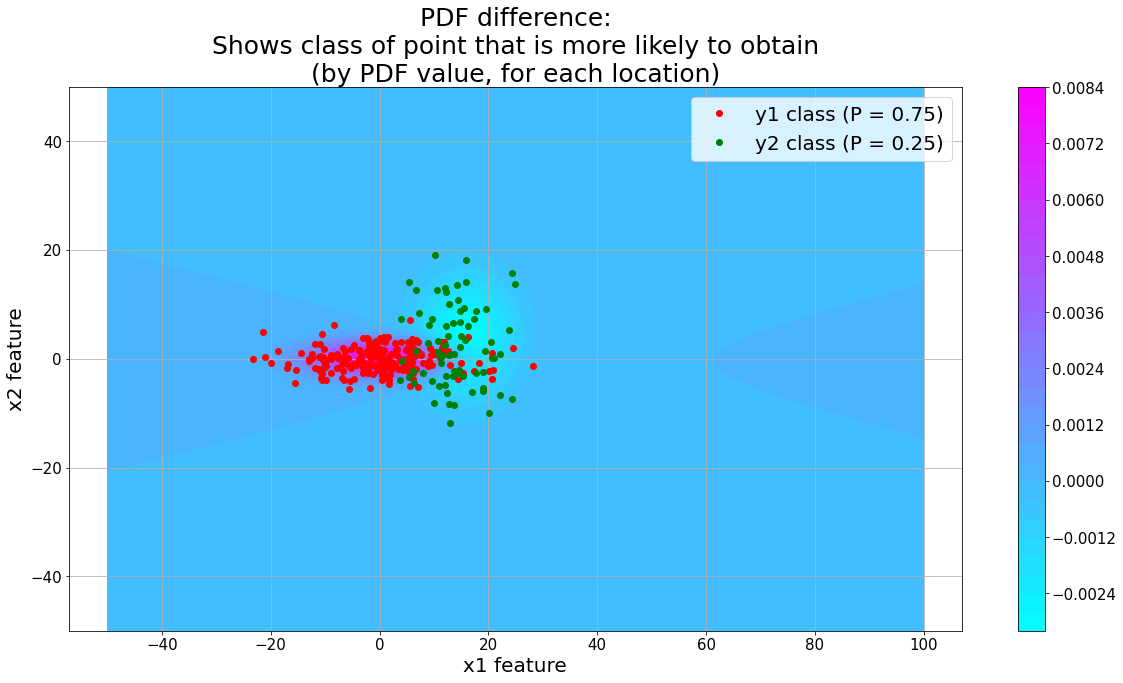

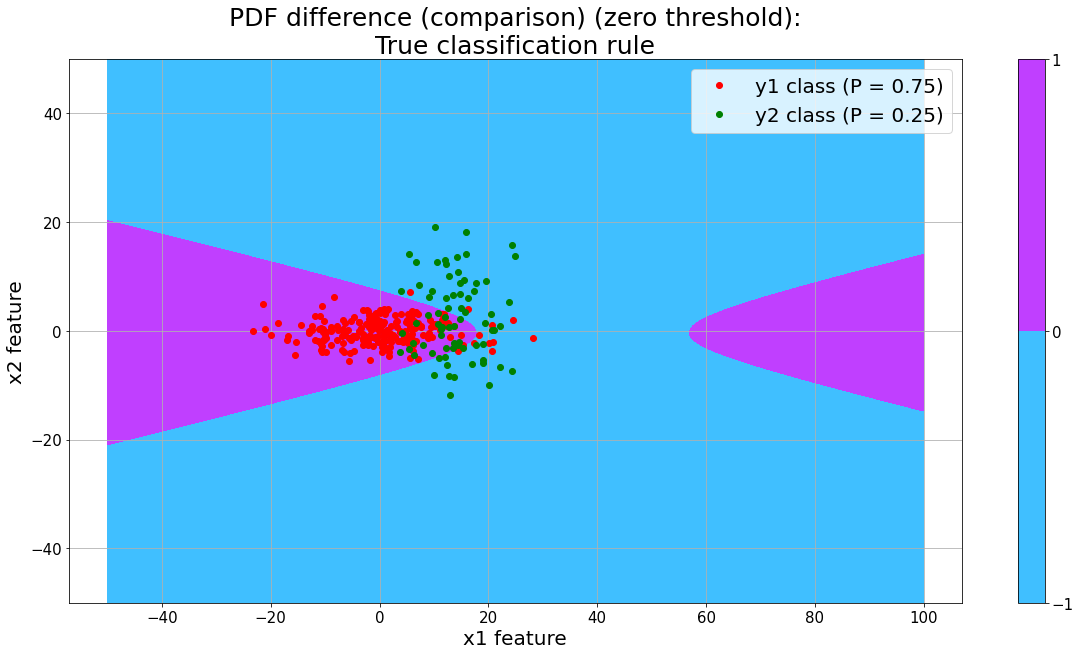

In [8]:
# TODO: clarify each evaluation with formulas (add)

# y1 and y2 PDF difference
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.contourf(x1_grid, x2_grid, y1.pdf(coords) - y2.pdf(coords), 30, cmap='cool')
plt.colorbar();
show_plot('PDF difference:\nShows class of point that is more likely to obtain\n(by PDF value, for each location)',
          'x1 feature', 'x2 feature')

# y1 and y2 PDF values comparison
plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.contourf(x1_grid, x2_grid, y1_prob * y1.pdf(coords) - (1 - y1_prob) * y2.pdf(coords), [-1, 0, 1], cmap='cool')
plt.colorbar();
show_plot('PDF difference (comparison) (zero threshold):\nTrue classification rule', 'x1 feature', 'x2 feature')

## Estimation

### Prior class probs

In [9]:
def estimate_prior_prob(target_class_id, classes):
    full_count = 0
    for c in classes:
        full_count += len(c)
    return len(classes[target_class_id]) / full_count

<BarContainer object of 1 artists>

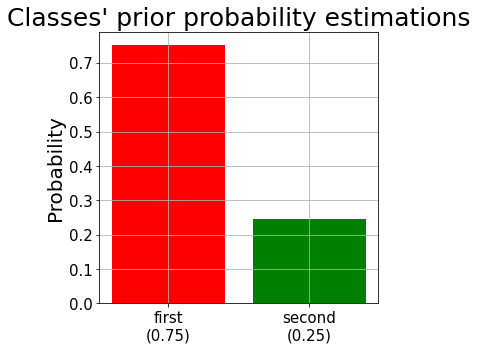

In [10]:
# TODO: add comparison with ground truth prior probabilities

# y1 class prior probability
y1_prior_prob = estimate_prior_prob(0, [y1_points, y2_points])

plt.figure(figsize=(5, 5))
plt.title('Classes\' prior probability estimations')
plt.ylabel('Probability')
plt.bar('first\n(%.2f)' % y1_prior_prob, y1_prior_prob, color='red')
plt.bar('second\n(%.2f)' % (1 - y1_prior_prob), 1 - y1_prior_prob, color='green')

### PDF estimation

In [11]:
# TODO: Use smooth kernel
# TODO: Use another estimators?

# Parzen window
def rect_kernel(z):
    return 0.5 * int(abs(z) < 1)

def density(x, points, d):
    sum = 0
    for p in points:
        sum += rect_kernel((x - p) / d)
    return 1 / (len(points) * d) * sum

def estimate_density(distr_points, d, test_points):
    return list(map(lambda p:
                        density(p, distr_points, d),
                    test_points))

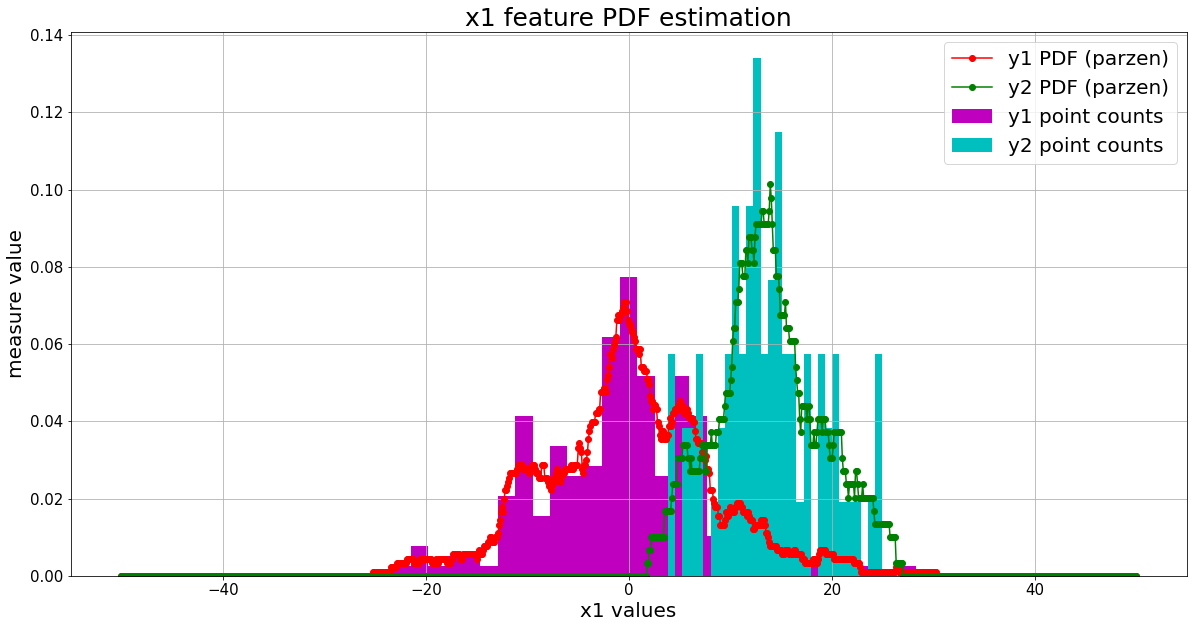

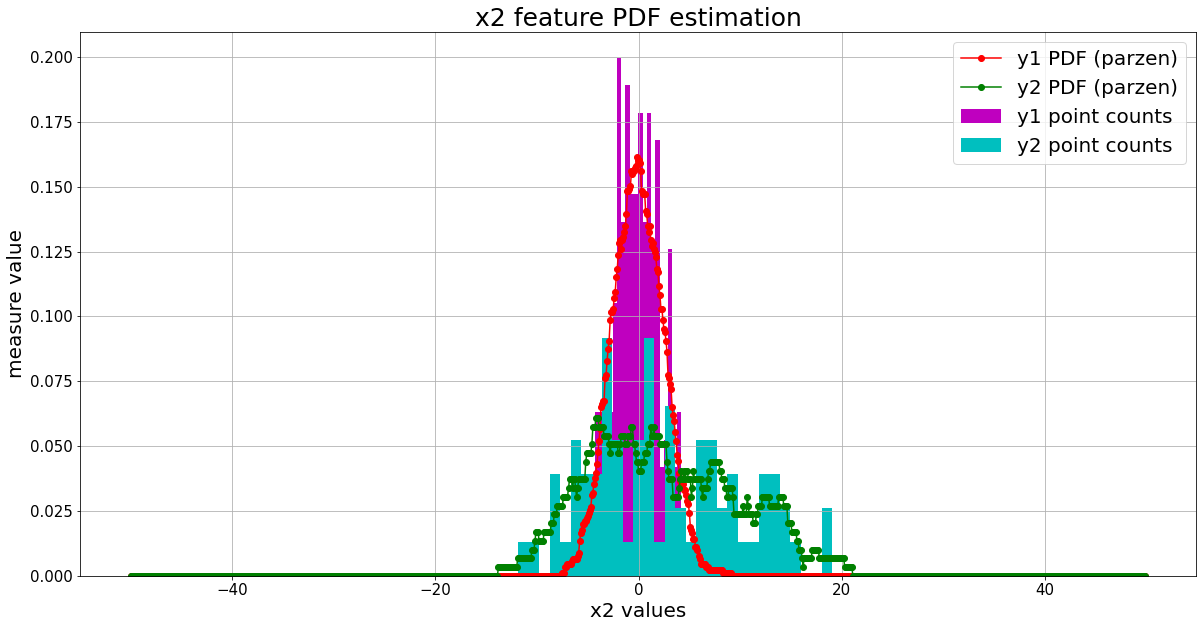

In [12]:
# TODO: calculate initial pdf and compare?

test_points = np.arange(-50, 50, 0.1)
window_size = 2

# x1 feature PDF of y1 class
y1_points_x1 = y1_points[:, 0]
plt.hist(y1_points_x1, density=True, bins=30, color='m', label='y1 point counts')

p11 = estimate_density(y1_points_x1, window_size, test_points)
plt.plot(test_points, p11, '-ro', label='y1 PDF (parzen)')


# x1 feature PDF of y2 class
y2_points_x1 = y2_points[:, 0]
plt.hist(y2_points_x1, density=True, bins=30, color='c', label='y2 point counts')

p21 = estimate_density(y2_points_x1, window_size, test_points)
plt.plot(test_points, p21, '-go', label='y2 PDF (parzen)')


show_plot('x1 feature PDF estimation', 'x1 values', 'measure value', axis_mode='auto')


# x2 feature PDF of y1 class
y1_points_x2 = y1_points[:, 1]
plt.hist(y1_points_x2, density=True, bins=30, color='m', label='y1 point counts')

p12 = estimate_density(y1_points_x2, window_size, test_points)
plt.plot(test_points, p12, '-ro', label='y1 PDF (parzen)')


# x2 feature PDF of y2 class
y2_points_x2 = y2_points[:, 1]
plt.hist(y2_points_x2, density=True, bins=30, color='c', label='y2 point counts')

p22 = estimate_density(y2_points_x2, window_size, test_points)
plt.plot(test_points, p22, '-go', label='y2 PDF (parzen)')


show_plot('x2 feature PDF estimation', 'x2 values', 'measure value', axis_mode='auto')



### Aposterior probability

In [13]:
# Very unstable in cases when prob values close to zero
def class_apost_prob(target_point, target_class_id, classes, window_size=5, eps=1e-6):
    target_class_prior_prob = estimate_prior_prob(target_class_id, classes)
    
    target_class_likelihood = 1
    for feature_id in range(classes[target_class_id].shape[1]):
        target_class_likelihood *= estimate_density(classes[target_class_id][:, feature_id], window_size, [target_point[feature_id]])[0]
    
    joint_distr_dens = target_class_prior_prob * target_class_likelihood
    
    inst_dens = 0
    for class_id in range(len(classes)):
        class_prior_prob = estimate_prior_prob(class_id, classes)
        
        class_likelihood = 1
        for feature_id in range(classes[class_id].shape[1]):
            class_likelihood *= estimate_density(classes[class_id][:, feature_id], window_size, [target_point[feature_id]])[0]
            
        inst_dens += class_prior_prob * class_likelihood
        
    return joint_distr_dens / (inst_dens + eps)

#### Single point class estimation

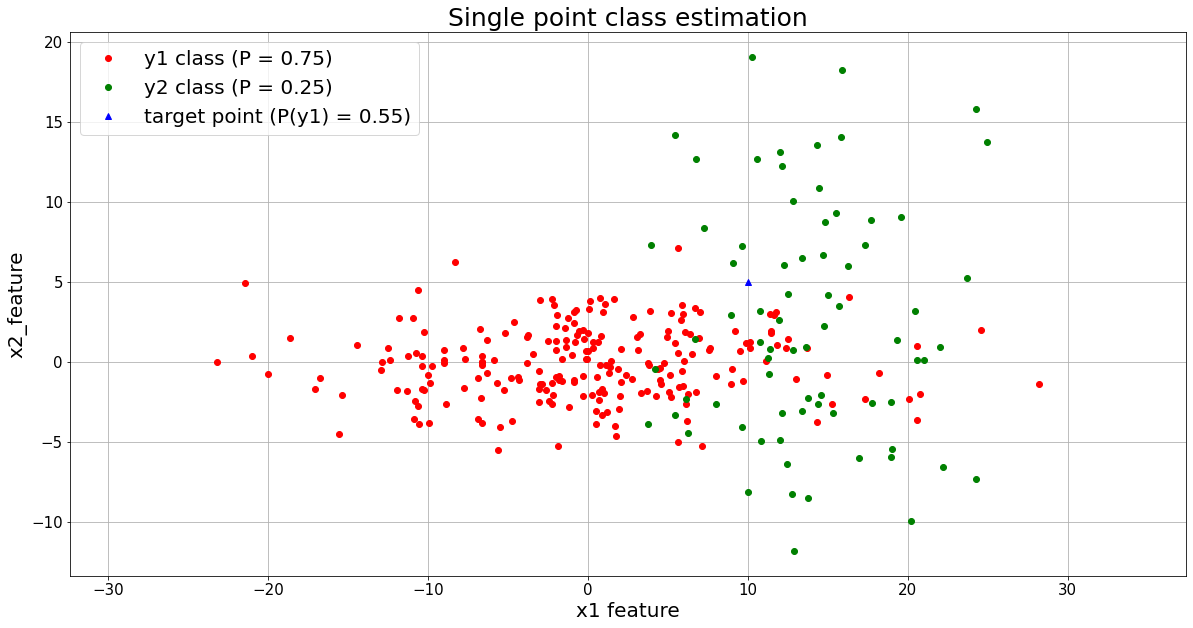

In [14]:
target_point = (10, 5)
target_point_prob = class_apost_prob(target_point, 0, [y1_points, y2_points])

plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class (P = %.2f)' % y1_prob)
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class (P = %.2f)' % (1 - y1_prob))
plt.plot(target_point[0], target_point[1], 'b^', label='target point (P(y1) = %.2f)' % target_point_prob)

show_plot('Single point class estimation', 'x1 feature', 'x2_feature')

#### Class map estimation

In [15]:
x1_size = 100
x2_size = 100
x1_space = np.linspace(-50, 100, x1_size)
# print(x1_space)
x2_space = np.linspace(-50, 50, x2_size)
# print(x2_space)

point_probs = []
window_size = 2
for x1 in tqdm(x1_space):
    for x2 in x2_space:
        point_probs.append(class_apost_prob((x1, x2), 0, [y1_points, y2_points], window_size))

100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


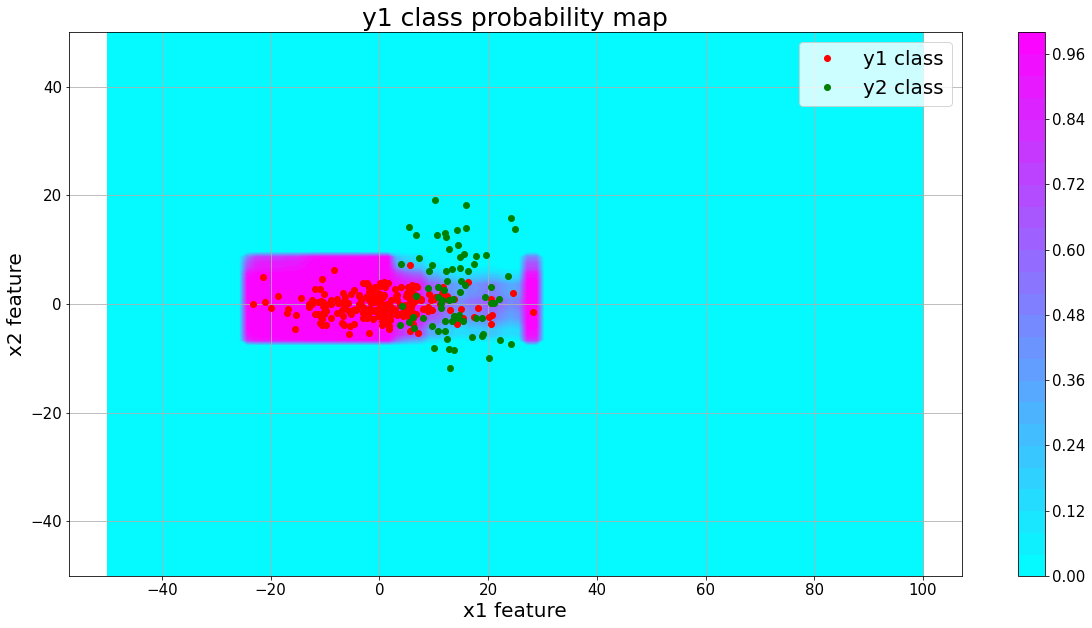

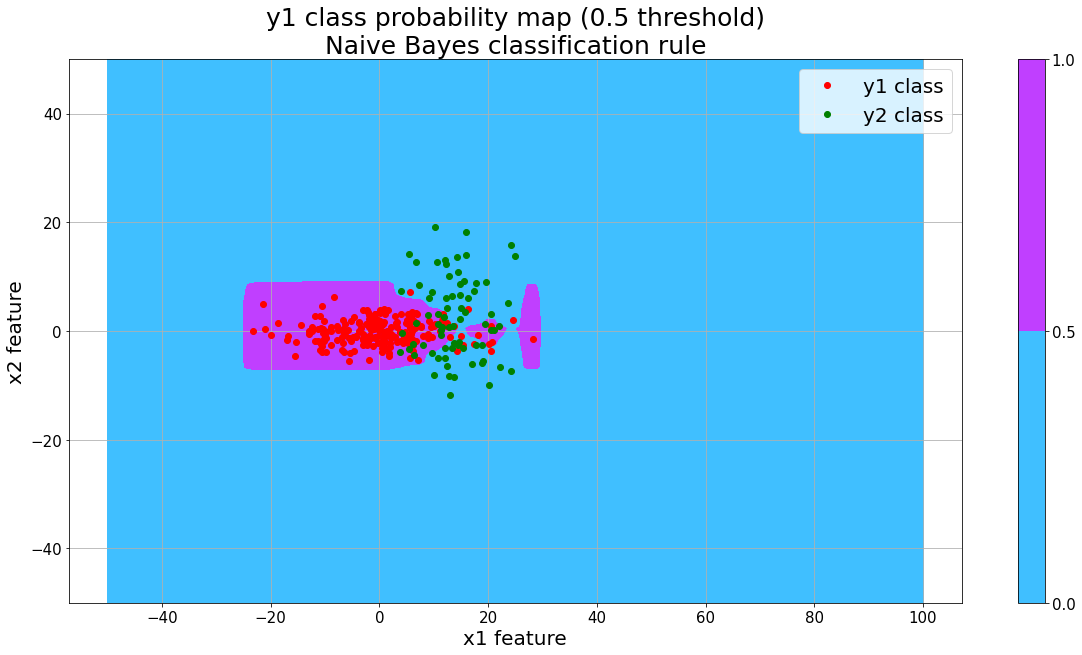

In [16]:
x1_grid, x2_grid = np.meshgrid(x1_space, x2_space, indexing='ij')
point_probs = np.array(point_probs).reshape((x1_size, -1))

plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class')
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class')
plt.contourf(x1_grid, x2_grid, point_probs, 30, cmap='cool')
plt.colorbar();
show_plot('y1 class probability map', 'x1 feature', 'x2 feature')

plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class')
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class')
plt.contourf(x1_grid, x2_grid, point_probs, [0, 0.5, 1], cmap='cool')
plt.colorbar();
show_plot('y1 class probability map (0.5 threshold)\nNaive Bayes classification rule', 'x1 feature', 'x2 feature')

### Joint Density

In [17]:
# TODO: still problem with close to zero values?
# TODO: Laplace smoothing?
# TODO: pass density estimator as parameter
# TODO: check it on ground truth PDFs
def joint_dist_dens_log(target_point, target_class_id, classes, window_size=5, eps=1e-3):
    target_class_prior_prob_log = log(eps + estimate_prior_prob(target_class_id, classes))
    
    target_class_likelihood_log = 0
    for feature_id in range(classes[target_class_id].shape[1]):
        target_class_likelihood_log += log(eps + estimate_density(classes[target_class_id][:, feature_id], window_size, [target_point[feature_id]])[0])
    
    return target_class_prior_prob_log + target_class_likelihood_log

#### Class map estimation

In [18]:
x1_size = 100
x2_size = 100
x1_space = np.linspace(-100, 100, x1_size)
# print(x1_space)
x2_space = np.linspace(-50, 50, x2_size)
# print(x2_space)

dens_logs_1 = []
dens_logs_2 = []
window_size = 2
for x1 in tqdm(x1_space):
    for x2 in x2_space:
        dens_logs_1.append(joint_dist_dens_log((x1, x2), 0, [y1_points, y2_points], window_size))
        dens_logs_2.append(joint_dist_dens_log((x1, x2), 1, [y1_points, y2_points], window_size))
        

100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


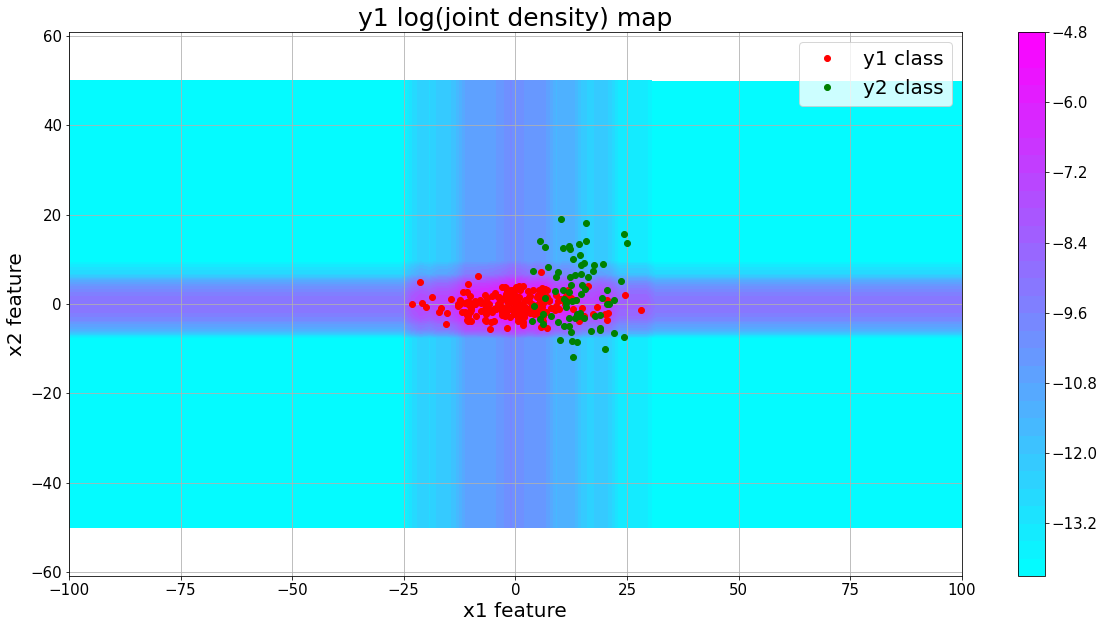

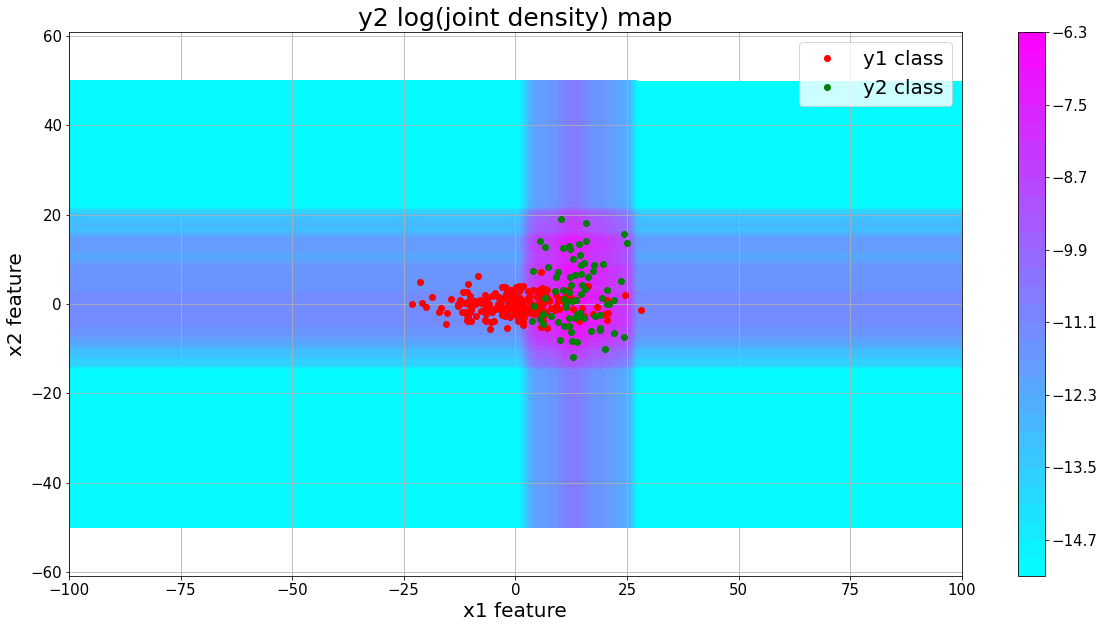

In [19]:
x1_grid, x2_grid = np.meshgrid(x1_space, x2_space, indexing='ij')
dens_logs_1 = np.array(dens_logs_1).reshape((x1_size, -1))
dens_logs_2 = np.array(dens_logs_2).reshape((x1_size, -1))


plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class')
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class')
plt.contourf(x1_grid, x2_grid, dens_logs_1, 30, cmap='cool')
plt.colorbar();
show_plot('y1 log(joint density) map', 'x1 feature', 'x2 feature')


plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class')
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class')
plt.contourf(x1_grid, x2_grid, dens_logs_2, 30, cmap='cool')
plt.colorbar();
show_plot('y2 log(joint density) map', 'x1 feature', 'x2 feature')

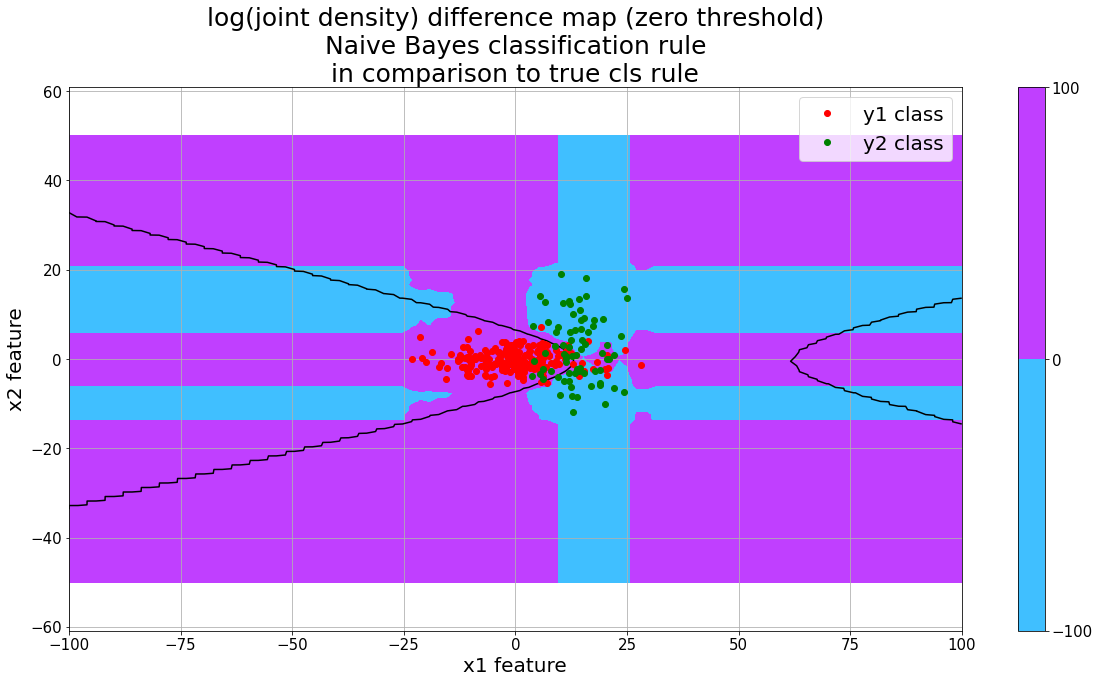

In [24]:
coords = np.empty(x1_grid.shape + (2,))
coords[:, :, 0] = x1_grid
coords[:, :, 1] = x2_grid


plt.plot(y1_points[:, 0], y1_points[:, 1], 'ro', label='y1 class')
plt.plot(y2_points[:, 0], y2_points[:, 1], 'go', label='y2 class')
plt.contourf(x1_grid, x2_grid, dens_logs_1 - dens_logs_2, [-100, 0, 100], cmap='cool')
plt.colorbar();

plt.contour(x1_grid, x2_grid, y1.pdf(coords) - y2.pdf(coords), [-1, 0, 1],
            colors='black')

show_plot('log(joint density) difference map (zero threshold)\nNaive Bayes classification rule\nin comparison to true cls rule',
          'x1 feature', 'x2 feature')

In [21]:
# TODO: Compare with sklearn Naive Bayes

# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB

# X, y = load_iris(return_X_y=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# gnb = GaussianNB()

# y_pred = gnb.fit(X_train, y_train).predict(X_test)

# print("Number of mislabeled points out of a total %d points : %d"
#        % (X_test.shape[0], (y_test != y_pred).sum()))